In [29]:
import torch
from tqdm import tqdm
import kaolin
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.animation import PillowWriter
from io import BytesIO
from PIL import Image
from itertools import product
import pandas as pd


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
lr_sites = 0.03
lr_model = 0.000003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/multiple_sites/"


Using device:  NVIDIA GeForce RTX 3090


In [30]:
# MLP + Positional Encoding
class Decoder(torch.nn.Module):
    def __init__(self, input_dims = 3, internal_dims = 128, output_dims = 1, hidden = 5, multires = 2):
        super().__init__()
        self.embed_fn = None
        if multires > 0:
            embed_fn, input_ch = get_embedder(multires)
            self.embed_fn = embed_fn
            input_dims = input_ch

        net = (torch.nn.Linear(input_dims, internal_dims, bias=False), torch.nn.ReLU())
        for i in range(hidden-1):
            net = net + (torch.nn.Linear(internal_dims, internal_dims, bias=False), torch.nn.ReLU())
        net = net + (torch.nn.Linear(internal_dims, output_dims, bias=False),)
        self.net = torch.nn.Sequential(*net)

    def forward(self, p):
        if self.embed_fn is not None:
            p = self.embed_fn(p)
        out = self.net(p)
        return out

    def pre_train_sphere(self, iter):
        print ("Initialize SDF to sphere")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            p = torch.rand((1024,3), device='cuda') - 0.5
            ref_value  = torch.sqrt((p**2).sum(-1)) - 0.3
            output = self(p) # sdf 0 , deform 1-3
            loss = loss_fn(output[...,0], ref_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Pre-trained MLP", loss.item())

    def pre_train_circle(self, iter):
        print("Initialize SDF to circle")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            # Generate random points in the 2D plane (x, y)
            p = torch.rand((1024, 2), device='cuda') - 0.5  # x and y values in the range [-0.5, 0.5]
            p = p*10
            # Calculate the reference value (SDF for circle)
            ref_value = torch.sqrt((p**2).sum(-1)) - 2.0  # Distance from origin (0, 0) minus the circle radius (2)

            # Get the network output
            output = self(p)
            
            # Compute the loss
            loss = loss_fn(output[..., 0], ref_value)
            
            # Perform backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Pre-trained MLP", loss.item())


# Positional Encoding from https://github.com/yenchenlin/nerf-pytorch/blob/1f064835d2cca26e4df2d7d130daa39a8cee1795/run_nerf_helpers.py
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']
        
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)
            
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)

def get_embedder(multires):
    embed_kwargs = {
                'include_input' : True,
                #'input_dims' : 3,
                'input_dims' : 2,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


In [31]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_

centroids = (np.array(centroids- 0.5))* 10.0
#make centroids double
centroids = centroids.astype(np.double)

#sites = torch.from_numpy(centroids).to(device).requires_grad_(True)

sites = torch.from_numpy(centroids).to(device, dtype=torch.double).requires_grad_(True)
print(sites.shape, sites.dtype)

torch.Size([128, 2]) torch.float64


In [32]:
def plot_sdf(ax, model):
            # Generate a grid of points
        grid_size = 1000
        x = np.linspace(-10.0, 10.0, grid_size)
        y = np.linspace(-10.0, 10.0, grid_size)
        xx, yy = np.meshgrid(x, y)
        grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
        
        # Convert grid points to a PyTorch tensor
        grid_points_tensor = torch.tensor(grid_points, device=device, dtype=torch.double)
        
        # Compute the SDF values
        sdf_values = model(grid_points_tensor)[:,0]
        sdf_values = sdf_values.reshape(grid_size, grid_size)
        #print(sdf_values)
        # Plot the SDF contour
        ax.contour(xx, yy, sdf_values.cpu().detach().numpy(), levels=[0] ,colors='black')

def star_sdf(vertices, r=3.0, rf=0.5, origin=torch.tensor([0.0, 0.0])):
    """
    Compute the SDF of a five-pointed star with a custom origin.

    Args:
        vertices (torch.Tensor): Input points, shape (N, 2).
        r (float): Outer radius of the star.
        rf (float): Ratio between the inner and outer radii of the star.
        origin (tuple): The origin of the star (x, y).

    Returns:
        torch.Tensor: SDF values for each point, shape (N,).
    """
    # Shift points relative to the origin
    p = vertices - origin

    # Define constants
    k1 = torch.tensor([0.809016994375, -0.587785252292], device=p.device, dtype=p.dtype)  # Cosine and sine for 72 degrees
    k2 = torch.tensor([-0.809016994375, -0.587785252292], device=p.device, dtype=p.dtype)  # Cosine and sine for -72 degrees

    # Reflect and transform the points without in-place modification
    p_reflected_x = torch.abs(p[:, 0]).unsqueeze(1)  # Reflect across the y-axis
    p_reflected = torch.cat((p_reflected_x, p[:, 1].unsqueeze(1)), dim=1)

    p_reflected -= 2.0 * torch.clamp(torch.sum(p_reflected * k1, dim=1, keepdim=True), min=0.0) * k1
    p_reflected -= 2.0 * torch.clamp(torch.sum(p_reflected * k2, dim=1, keepdim=True), min=0.0) * k2

    # Reflect again across the y-axis
    p_reflected_x2 = torch.abs(p_reflected[:, 0]).unsqueeze(1)
    p_reflected = torch.cat((p_reflected_x2, p_reflected[:, 1].unsqueeze(1)), dim=1)

    # Shift downwards
    p_reflected_y_shift = (p_reflected[:, 1] - r).unsqueeze(1)
    p_reflected = torch.cat((p_reflected[:, 0].unsqueeze(1), p_reflected_y_shift), dim=1)

    # Vector to the inner vertices
    ba = rf * torch.tensor([-k1[1], k1[0]], device=p.device, dtype=p.dtype) - torch.tensor([0, 1], device=p.device, dtype=p.dtype)
    
    # Projection along ba
    h = torch.clamp(torch.sum(p_reflected * ba, dim=1) / torch.sum(ba * ba), min=0.0, max=r)
    
    # Compute distance and sign
    dist = torch.norm(p_reflected - h.unsqueeze(1) * ba, dim=1)
    sign = torch.sign(p_reflected[:, 1] * ba[0] - p_reflected[:, 0] * ba[1])
    
    return dist * sign

def compute_edge_smoothing_loss(edges, sites, model):
    """
    Computes the loss to smooth edges by minimizing the dot product between the 
    edge orientation and the gradient of the SDF at the midpoint of the edge, without a loop.
    
    Args:
        edges: Tensor of edges, each defined as [v1_idx, v2_idx, site1_idx, site2_idx].
        sites: Tensor of site positions.
        model
    
    Returns:
        smoothing_loss: The computed edge smoothing loss.
    """
    # Extract indices for vertices and sites
    v1_idx, v2_idx, site1_idx, site2_idx = edges[:, 0], edges[:, 1], edges[:, 2], edges[:, 3]
    
    # Extract positions of site1 and site2
    site1 = sites[site1_idx]  # Shape: (M, D)
    site2 = sites[site2_idx]  # Shape: (M, D)
    
    # Compute site direction and edge orientation
    site_direction = site2 - site1  # Shape: (M, D)
    site_direction = site_direction / torch.norm(site_direction, dim=1, keepdim=True)  # Normalize
    
    # Perpendicular orientation (2D case)
    edge_orientation = torch.stack([-site_direction[:, 1], site_direction[:, 0]], dim=1)  # Shape: (M, 2)
    
    # Compute midpoints of edges
    midpoints = (site1 + site2) / 2.0  # Shape: (M, D)
    midpoints.requires_grad_(True)  # Enable gradient tracking for midpoints
    
    # Compute SDF values at midpoints
    sdf_values = model(midpoints)[:,0]
    
    # Compute SDF gradients at midpoints
    torch.autograd.set_detect_anomaly(True)
    gradients_sdf = torch.autograd.grad(sdf_values, midpoints, grad_outputs=torch.ones_like(sdf_values), create_graph=True)[0]  # Shape: (M, D)
    
    # Dot product between edge orientation and SDF gradient
    dot_products = torch.sum(edge_orientation * gradients_sdf, dim=1)  # Shape: (M,)
    
    # Compute smoothing loss
    smoothing_loss = torch.mean(dot_products**2)  # Scalar

    return smoothing_loss

def compute_cvt_loss(sites):
    # Compute the Voronoi diagram based on the current site locations
    vor = Voronoi(sites.detach().cpu().numpy())
    
    centroids = []
    for i in range(len(sites)):
        # Find the region corresponding to the current site
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        # Check if the region is valid (i.e., finite and non-empty)
        if -1 not in region and len(region) > 0:
            # Compute the centroid as the mean of the vertices in this region
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)
        else:
            # For regions that are unbounded, return the site itself as the centroid
            centroid = sites[i].detach().cpu().numpy()
        
        centroids.append(centroid)
    
    centroids = torch.tensor(centroids, device=sites.device)
    
    # Calculate the CVT loss using Mean Squared Error
    cvt_loss = torch.mean(torch.norm(sites - centroids, p=2, dim=1) ** 2)
    #cvt_loss = torch.mean(torch.sum(torch.norm(sites - centroids, p=2, dim=1) ** 2))
    
    return cvt_loss

def min_distance_regularization_for_op_sites(edges, sites):
    
    # Extract unique sites indices from edges 
    # edges has 4 columns, 0,1 vertex, 2,3 sites
    unique_indices = torch.unique(edges[:,2:4].flatten())
    
    # Select sites corresponding to unique indices
    sites_optimized = torch.stack([sites[i] for i in unique_indices])
    
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites_optimized, sites_optimized, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    #regularization_loss = torch.mean(torch.sum(penalties**2))
    regularization_loss = torch.mean(penalties**2)
    
    
    return regularization_loss

def chamfer_distance(pred_point_cloud, true_point_cloud):
    # Compute pairwise distances
    # From point cloud to mesh edge points
    dist1 = torch.cdist(true_point_cloud, pred_point_cloud).min(dim=1)[0]
    # From mesh edge points to point cloud
    dist2 = torch.cdist(pred_point_cloud, true_point_cloud).min(dim=1)[0]
    # Chamfer distance is the sum (or average) of these distances
    chamfer_dist = torch.mean(dist1) + torch.mean(dist2)
    return chamfer_dist


In [33]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors

def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])

def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices

# def get_sites_zero_crossing_edges(sites, model):
#     sites_np = sites.detach().cpu().numpy()
#     # Compute Voronoi diagram
#     vor = Voronoi(sites_np)

#     # Compute SDF values for each site
#     sdf_values = model(sites)[:,0]
#     sdf_values = sdf_values.detach().cpu().numpy()

#     edges = []
#     for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
#         # Check if vertices are valid (not -1, which indicates infinity)
#         if vertex1 == -1 or vertex2 == -1:
#             continue
        
#         # Check if the sites have different signs
#         if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
#             edges.append((vertex1, vertex2, point1, point2))
#     edges = torch.tensor(edges)
#     return edges

def get_sites_zero_crossing_edges_random_points(sites, model, num_points_per_edge=1):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = model(sites)
    #sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if torch.sign(sdf_values[point1]) != torch.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2, point1, point2))

    edges = torch.tensor(edges).cpu()
    
    if len(edges) == 0:
        return None, None
    
    v1 = vor.vertices[edges[:, 0]]  # Shape: (M, D)
    v2 = vor.vertices[edges[:, 1]]  # Shape: (M, D)

    v1 = torch.tensor(v1, device=device)
    v2 = torch.tensor(v2, device=device)

    # Generate random interpolation factors `t` for each edge
    t = torch.rand((edges.size(0), num_points_per_edge), device=device)  # Shape: (M, num_points_per_edge)

    # Interpolate points along the edges
    random_points = (1 - t.unsqueeze(-1)) * v1.unsqueeze(1) + t.unsqueeze(-1) * v2.unsqueeze(1)  # Shape: (M, num_points_per_edge, D)

    # Reshape to a single list of points
    random_points = random_points.view(-1,v1.size(1))  # Shape: (M * num_points_per_edge, D)
    
    return edges, random_points

# def random_points_on_edges(vertices, edges, num_points_per_edge=1):
#     """
#     Generate random points on edges of a mesh using PyTorch.

#     Args:
#         vertices (torch.Tensor): Tensor of shape (N, D), where N is the number of vertices and D is the dimensionality (e.g., 2 or 3).
#         edges (torch.Tensor): Tensor of shape (M, 2), where M is the number of edges, containing vertex indices defining edges.
#         num_points_per_edge (int): Number of random points to sample on each edge.

#     Returns:
#         torch.Tensor: Tensor of shape (M * num_points_per_edge, D) containing random points sampled on edges.
#     """
#     # Get the vertex positions for the edges
#     print(vertices[edges[:, 0]].shape, vertices[edges[:, 1]].shape)
#     v1 = vertices[edges[:, 0]]  # Shape: (M, D)
#     v2 = vertices[edges[:, 1]]  # Shape: (M, D)

#     # Generate random interpolation factors `t` for each edge
#     t = torch.rand((edges.size(0), num_points_per_edge), device=vertices.device)  # Shape: (M, num_points_per_edge)

#     # Interpolate points along the edges
#     random_points = (1 - t.unsqueeze(-1)) * v1.unsqueeze(1) + t.unsqueeze(-1) * v2.unsqueeze(1)  # Shape: (M, num_points_per_edge, D)

#     # Reshape to a single list of points
#     random_points = random_points.view(-1, vertices.size(1))  # Shape: (M * num_points_per_edge, D)

#     return random_points


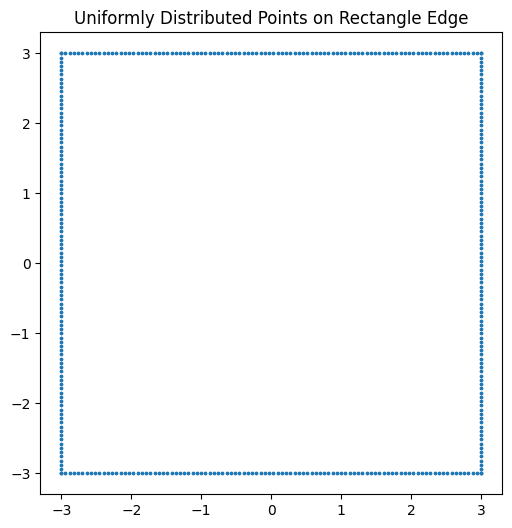

Points shape:  torch.Size([400, 2])


In [34]:
import torch
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters
num_points = 400  # Total number of points
width, height = 1.0, 1.0  # Rectangle dimensions (centered at 0,0)

# Generate points for each edge
num_edge_points = num_points // 4

# Top edge (y = height / 2)
top_edge = torch.stack([
    torch.linspace(-width / 2, width / 2, num_edge_points, device=device),
    torch.full((num_edge_points,), height / 2, device=device)
], dim=1)

# Bottom edge (y = -height / 2)
bottom_edge = torch.stack([
    torch.linspace(-width / 2, width / 2, num_edge_points, device=device),
    torch.full((num_edge_points,), -height / 2, device=device)
], dim=1)

# Right edge (x = width / 2)
right_edge = torch.stack([
    torch.full((num_edge_points,), width / 2, device=device),
    torch.linspace(-height / 2, height / 2, num_edge_points, device=device)
], dim=1)

# Left edge (x = -width / 2)
left_edge = torch.stack([
    torch.full((num_edge_points,), -width / 2, device=device),
    torch.linspace(-height / 2, height / 2, num_edge_points, device=device)
], dim=1)

# Combine all edges
true_points = torch.cat([top_edge, bottom_edge, right_edge, left_edge], dim=0)

# Scale points (if needed)
true_points = true_points * 6.0  # Scaled by a factor of 3.0

# Plot points
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)  # Adjust marker size
plt.title("Uniformly Distributed Points on Rectangle Edge")
plt.show()

print("Points shape: ", true_points.shape)



In [35]:
sdf_loss_values = []
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, lambda_weights = [0.1,1.0,0.1,0.1,1.0]):
    #optimizer = torch.optim.Adam([sites], lr=learning_rate)
    # vars = [p for _, p in model.named_parameters()] + [sites]
    # optimizer = torch.optim.Adam(vars, lr=lr)
    
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
])

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    gif_fn = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif'
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    last_edges = torch.tensor([])
    last_random_points = torch.tensor([])
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        #vertices_to_compute = zerocrossing_optim(neighbors, sites, sdf_fct)
        vertices_to_compute = compute_vertices_index(neighbors)
        vertices = compute_all_vertices(sites, vertices_to_compute)
        
        #compute edge point to be optimized instead of the vertices
        edges, random_points = get_sites_zero_crossing_edges_random_points(sites, model, num_points_per_edge=1)
        
        if edges is not None:
            last_edges = edges
            last_random_points = random_points
        else: 
            print("No zero crossing edges found, keeping last edges")
            edges = last_edges
            random_points = last_random_points
        
        # Compute losses       
        sdf_loss = torch.mean(model(random_points)[:,0]**2)
        cvt_loss = compute_cvt_loss(sites)
        min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = chamfer_distance(random_points, true_points)
        
        # Track raw losses (unweighted)
        sdf_loss_values.append(sdf_loss.item())
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
  
        ##todo maybe keep a cvt in the beginning and after max_iter/2 remove cvt and add laplacian
        loss = (
            lambda_sdf * sdf_loss +
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss
        )
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        # print(optimizer.param_groups[0]['params'])
        #torch.nn.utils.clip_grad_norm_(optimizer.param_groups[0]['params'], max_norm=0.1, norm_type=2)  # Adjust max_norm as needed
        
        torch.nn.utils.clip_grad_norm_([p for _, p in model.named_parameters()], max_norm=0.1)
        
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            break
        
        prev_loss = loss.item() 
               
        # if epoch == max_iter/2 and upsampled < 3:
        #     print("sites length: ",len(sites))
        #     #new_sites = detect_cells_for_upsampling(best_sites, sdf_fct)
        #     new_sites = upsampling_inside(best_sites, sdf_fct)
        #     sites = add_upsampled_sites(best_sites, new_sites)
        #     sites = sites.detach().requires_grad_(True)
        #     print("upsampled sites length: ",len(sites))
            
        #     best_sites = sites.clone()
        #     best_sites.best_loss = best_loss
            
        #     optimizer = torch.optim.Adam([sites], lr=learning_rate)
        #     upsampled += 1.0
        #     #lambda_cvt = 1.0
        #     #lambda_sdf = 3.0
        #     #lambda_min_distance = 0.1
        #     max_iter += max_iter

        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        plot_sdf(ax, model)
        ax.scatter(true_points[:,0].cpu(), true_points[:,1].cpu(), color='green', s=1)
        #plot random points
        ax.scatter(random_points[:,0].detach().cpu().numpy(), random_points[:,1].detach().cpu().numpy(), color='red', s=30) 
       
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
                        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            # Save the GIF
            gif_frames[0].save(
                f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
                save_all=True,            
                append_images=gif_frames[1:],
                duration=100,  # Duration in ms between frames
                loop=0
            )
            print("GIF saved as ",f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
)
                    
        epoch += 1
            
    # Save the GIF
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

Initialize SDF to circle


100%|██████████| 10000/10000 [00:15<00:00, 631.65it/s]


Pre-trained MLP 1.8083846366011295e-05


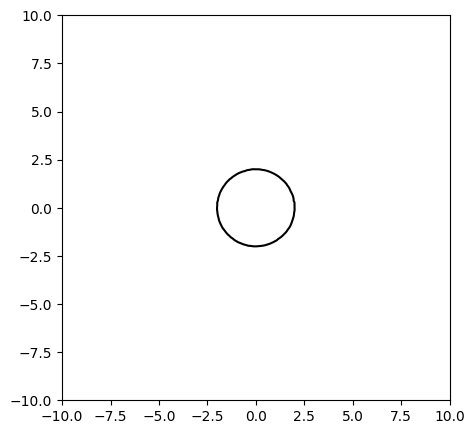

In [36]:
# Initialize model and create optimizer
model = Decoder(multires=multires).to(device)
model.pre_train_circle(10000)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
plot_sdf(ax, model)
#equal

plt.show()


In [37]:
# sdf_fct = star_sdf
# #sdf_fct = box_sdf
# #sdf_fct = torus_sdf
# #lambda_weights=[0.1,1.0,0.0,0.2]
# lambda_weights=[0.1,1.0,0.1,0.0]

lambda_weights = [0.1,0.0,0.1,0.1,3.0]
lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
max_iter = 500

site_file_path = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
    #load model from file
    model = Decoder(multires=multires).to(device)
    model.load_state_dict(torch.load(f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.pth'))   
    
else:
    sites = autograd(sites, model, max_iter=max_iter, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    #save model
    torch.save(model.state_dict(), f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.pth')


print("Sites: ", sites)

Importing sites
Sites:  tensor([[-5.4220,  1.1576],
        [ 1.0968,  0.7665],
        [-1.2839, -1.9749],
        [ 4.9291,  0.3269],
        [-1.1036,  1.3575],
        [ 3.8352, -2.8132],
        [-5.1913, -2.9395],
        [ 0.4892, -0.3208],
        [ 3.6268,  2.2970],
        [-4.6283,  4.4427],
        [-1.4881, -0.3738],
        [ 0.3683,  2.0956],
        [ 2.1919, -1.6312],
        [-2.5690, -4.4936],
        [-3.4706,  5.1322],
        [ 2.8331,  2.8735],
        [ 2.4793, -5.5597],
        [-0.4832,  0.1826],
        [-1.9942, -5.6323],
        [ 5.2425, -2.5973],
        [-0.9486,  2.7028],
        [-3.5001,  2.1296],
        [-0.8927, -1.3602],
        [-3.3366,  1.3042],
        [ 0.3780, -1.0183],
        [ 1.8998,  0.8248],
        [ 4.5904,  4.4470],
        [-1.9739, -1.5666],
        [ 2.6690,  3.7858],
        [ 1.3863,  1.2294],
        [ 0.1438,  1.2637],
        [ 0.0792, -1.5638],
        [-1.5653,  0.2414],
        [ 3.6801, -4.9760],
        [-1.4470,  0.771

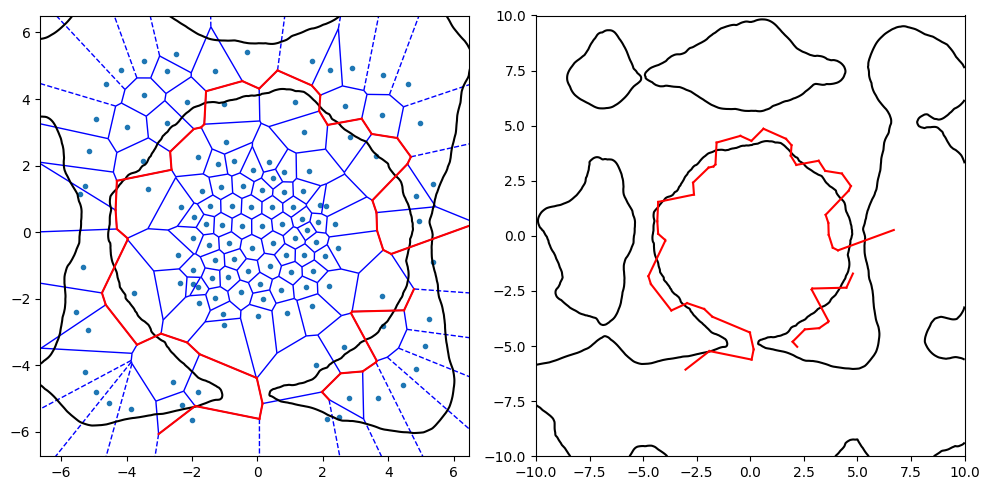

In [38]:
def get_sites_zero_crossing_edges(sites, model):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = model(sites)[:,0]
    sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2))
    
    
        # Create two subplots: one with Voronoi diagram and one without
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot with Voronoi diagram
    ax1 = axs[0]
    voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
    plot_sdf(ax1, model)

    #ax1.set_title("With Voronoi Diagram")

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax1.legend(['Zero-crossing edges'], loc='upper right')

    # Plot without Voronoi diagram
    ax2 = axs[1]
    plot_sdf(ax2, model)

    #ax2.set_title("Without Voronoi Diagram")
    #plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax2.legend(['Zero-crossing edges'], loc='upper right')
    # plt.plot([], [], 'r-', label='sites zero-crossing edge')
    # limit of the plot
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.tight_layout()
    plt.savefig(f'{destination}edge_sdf_crossing.png')
    
    plt.show()            
            
    return edges


edges = get_sites_zero_crossing_edges(sites, model)



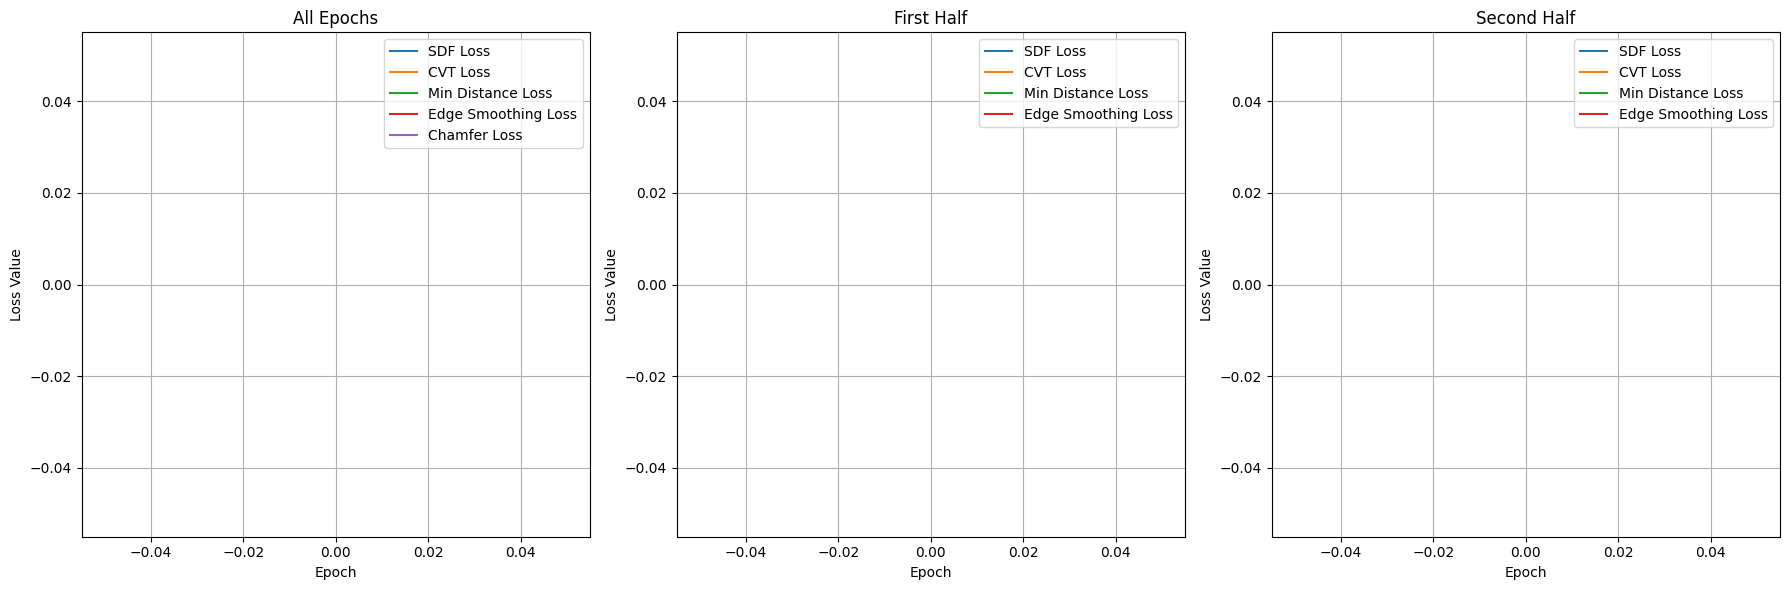

In [39]:
# Define the total number of epochs and split into halves
total_epochs = len(sdf_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
axes[0].plot(range(total_epochs), sdf_loss_values, label="SDF Loss")
axes[0].plot(range(total_epochs), cvt_loss_values, label="CVT Loss")
axes[0].plot(range(total_epochs), min_distance_loss_values, label="Min Distance Loss")
axes[0].plot(range(total_epochs), edge_smoothing_loss_values, label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), chamfer_distance_loss_values, label="Chamfer Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
axes[1].plot(range(half_epoch), sdf_loss_values[:half_epoch], label="SDF Loss")
axes[1].plot(range(half_epoch), cvt_loss_values[:half_epoch], label="CVT Loss")
axes[1].plot(range(half_epoch), min_distance_loss_values[:half_epoch], label="Min Distance Loss")
axes[1].plot(range(half_epoch), edge_smoothing_loss_values[:half_epoch], label="Edge Smoothing Loss")
# axes[1].plot(range(half_epoch), chamfer_distance_loss_values, label="Chamfer Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
axes[2].plot(range(half_epoch, total_epochs), sdf_loss_values[half_epoch:], label="SDF Loss")
axes[2].plot(range(half_epoch, total_epochs), cvt_loss_values[half_epoch:], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), min_distance_loss_values[half_epoch:], label="Min Distance Loss")
axes[2].plot(range(half_epoch, total_epochs), edge_smoothing_loss_values[half_epoch:], label="Edge Smoothing Loss")
# axes[2].plot(range(half_epoch), chamfer_distance_loss_values, label="Chamfer Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
